In [1]:
%matplotlib ipympl

In [2]:
from matplotlib.pyplot import figure, subplots, subplot_mosaic, get_cmap, close
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
import numpy
import matplotlib
from matplotlib import pylab, mlab, pyplot
np = numpy
plt = pyplot

from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs
from numpy import *
from numpy.linalg import *
from numpy.random import *
from numpy.fft import *

In [3]:
from pandas import read_csv, read_excel, concat as pdconcat
from shapely.geometry import Point, Polygon
from geopandas import GeoDataFrame, read_file
from geodatasets import get_path, data

In [4]:
from scipy.interpolate import CubicSpline
from scipy.io import whosmat, loadmat

In [5]:
myvars = locals()

# Load data into workspace and perform computations

In [6]:
_data = load("../data/processed_results_siteVariation_P2Eratio_0.25_outarray.npz")
for key, val in _data.items():
    if isinstance(val, ndarray):
        myvars[key] = val.squeeze()

In [7]:
_data = read_excel("../data/Sample data for battery use optimization r3.xlsx")

In [22]:
supply_df = read_csv("../data/gac_sol_1.0mw_supply-curve-aggregation.csv")
tot_num_sites = len(supply_df)

In [39]:
sorted_df = supply_df.sort_values(by=["capacity"])
sorted_df_gid = sorted_df["sc_gid"].to_numpy()
sorted_df_reduced = sorted_df
sorted_df_reduced_gid = sorted_df_reduced["sc_gid"].to_numpy()
tot_red_sites = len(sorted_df_reduced)

In [24]:
t_h = _data["Time (hrs)"].to_numpy()
grid_CO2_t = _data["Grid_CO2_hrs (kg)"].to_numpy()/907.185
excess_load_demand_MW = _data["Grid_Energy_hrs (kWh)"]/1e3
load_demand = excess_load_demand_MW.sum()
avail_solar_cap_MW = _data["DER_Solar1MW_Pwr (MW)"].to_numpy()

In [25]:
df_solarCapEx = read_excel("../data/SolarCapEX.xlsx")
solar_capacity_data = df_solarCapEx["Capacity (MW)"].to_numpy()
solar_cap_cost_data = df_solarCapEx["Solar Capital Cost"].to_numpy()

cs = CubicSpline(solar_capacity_data, solar_cap_cost_data)

In [26]:
df_batteryCapEx = read_excel("../data/BatteryStorageCapEx.xlsx", sheet_name="35 GWh")
battery_capacity_data = df_batteryCapEx["Power (MW)"].to_numpy()
NMC_cap_cost_data = df_batteryCapEx["NMC"].to_numpy()
NCA_cap_cost_data = df_batteryCapEx["NCA"].to_numpy()
LFP_cap_cost_data = df_batteryCapEx["LFP"].to_numpy()

NMC_cs = CubicSpline(battery_capacity_data, NMC_cap_cost_data)
NCA_cs = CubicSpline(battery_capacity_data, NCA_cap_cost_data)
LFP_cs = CubicSpline(battery_capacity_data, LFP_cap_cost_data)

In [43]:
_temp_data = load("../data/processed_results_siteVariation_P2Eratio_0.25_outarray.npz")
for key, val in _temp_data.items():
    if isinstance(val, ndarray):
        myvars[key] = val.squeeze()

In [44]:
solar_sizes = linspace(0.0, 1000.0, 101)
battery_sizes = linspace(0.0, 100.0, 100//10 + 1)

SOLAR, BATTERY = meshgrid(solar_sizes, battery_sizes, indexing="ij")

In [45]:
def compute_LCOPR(OCS, PV2GRID, PR, N, E0):
    
    numerator = OCS - PV2GRID*N*PR
    denominator = N*E0

    if E0 == 0.0:
        return 0.0
    else:
        return numerator/denominator

In [46]:
def compute_LCOS(OCS, E_rated, N_EOL):

    numerator = OCS
    denominator = N_EOL*E_rated

    if E_rated == 0.0:
        return 0.0
    else:
        return numerator/denominator

In [47]:
solar_sizes = linspace(0.0, 1000.0, 101)
battery_sizes = linspace(0.0, 100.0, 11)

theoretical_total_cost_NMC = zeros((len(solar_sizes), len(battery_sizes)))
theoretical_total_cost_NCA = zeros((len(solar_sizes), len(battery_sizes)))
theoretical_total_cost_LFP = zeros((len(solar_sizes), len(battery_sizes)))

duration = 4.0

for i, nameplate_solar_cap in enumerate(solar_sizes[1:]):
    theoretical_total_cost_NMC[i+1, 1:] = cs(nameplate_solar_cap) + NMC_cs(battery_sizes[1:]/duration)
    theoretical_total_cost_NCA[i+1, 1:] = cs(nameplate_solar_cap) + NCA_cs(battery_sizes[1:]/duration)
    theoretical_total_cost_LFP[i+1, 1:] = cs(nameplate_solar_cap) + LFP_cs(battery_sizes[1:]/duration)

max_cost_common = max([theoretical_total_cost_NMC.max(), theoretical_total_cost_NCA.max(), theoretical_total_cost_LFP.max()])

In [48]:
theoretical_LCOPR_woReturns = zeros((101, 3))
theoretical_LCOPR_wReturns = zeros((101, 3))
solar_sizes = linspace(0.0, 1000.0, 101)
hours_shift = array([-4, 0, 4])

for i, nameplate_solar_cap in enumerate(solar_sizes):
    for j, shift in enumerate(hours_shift):
        theoretical_LCOPR_woReturns[i, j] = compute_LCOPR(OCS=cs(nameplate_solar_cap),  
                                                   PV2GRID=tot_solar_curtailed_optimal[i, j, 0], 
                                                   PR=0.0, 
                                                   N=30, 
                                                   E0=tot_solar[i, j, 0], 
                                                   )
        theoretical_LCOPR_wReturns[i, j] = compute_LCOPR(OCS=cs(nameplate_solar_cap),  
                                                  PV2GRID=tot_solar_curtailed_optimal[i, j, 0], 
                                                  PR=48.0, 
                                                  N=30, 
                                                  E0=tot_solar[i, j, 0], 
                                                  )

In [49]:
battery_sizes = linspace(0.0, 100.0, 100//10 + 1)
batt_LCOS = zeros((3, len(battery_sizes)))

rated_duration_h = 4.0

for i, batt_size in enumerate(battery_sizes):
    
    if i == 0:
        continue
        
    batt_LCOS[0, i] = compute_LCOS(OCS=NMC_cs(batt_size/rated_duration_h), 
                                   E_rated=batt_size, 
                                   N_EOL=2000)
    batt_LCOS[1, i] = compute_LCOS(OCS=NCA_cs(batt_size/rated_duration_h), 
                                   E_rated=batt_size,
                                   N_EOL=1400)
    batt_LCOS[2, i] = compute_LCOS(OCS=LFP_cs(batt_size/rated_duration_h), 
                                   E_rated=batt_size,  
                                   N_EOL=6000)

In [50]:
site_cost_total_NMC = zeros((2, 3, 171))
site_cost_total_NCA = zeros((2, 3, 171))
site_cost_total_LFP = zeros((2, 3, 171))

for j in range(3):
    for i in range(171):
        nameplate_solar_cap = sorted_df_reduced.iloc[i]["capacity"].item()
        site_cost_total_NMC[0, j, i] = cs(nameplate_solar_cap)
        site_cost_total_NMC[1, j, i] = cs(nameplate_solar_cap) + NMC_cs(25.0)

        site_cost_total_NCA[0, j, i] = cs(nameplate_solar_cap)
        site_cost_total_NCA[1, j, i] = cs(nameplate_solar_cap) + NCA_cs(25.0)

        site_cost_total_LFP[0, j, i] = cs(nameplate_solar_cap)
        site_cost_total_LFP[1, j, i] = cs(nameplate_solar_cap) + LFP_cs(25.0)

In [51]:
site_LCOPR_woReturns = zeros((171, 3))
site_LCOPR_wReturns = zeros((171, 3))

for i in range(171):
    for j in range(3):
        nameplate_solar_cap = sorted_df_reduced.iloc[i]["capacity"].item()
        site_LCOPR_woReturns[i, j] = compute_LCOPR(OCS=cs(nameplate_solar_cap),  
                                                   PV2GRID=tot_solar_curtailed_optimal[sorted_df_reduced_gid[i], j, 0], 
                                                   PR=0.0, 
                                                   N=30, 
                                                   E0=tot_solar[sorted_df_reduced_gid[i], j, 0], 
                                                   )
        site_LCOPR_wReturns[i, j] = compute_LCOPR(OCS=cs(nameplate_solar_cap),  
                                                  PV2GRID=tot_solar_curtailed_optimal[sorted_df_reduced_gid[i], j, 0], 
                                                  PR=48.0, 
                                                  N=30, 
                                                  E0=tot_solar[sorted_df_reduced_gid[i], j, 0], 
                                                  )

# Figure S13: Breakdown of resource usage for each site to power the excess load demand

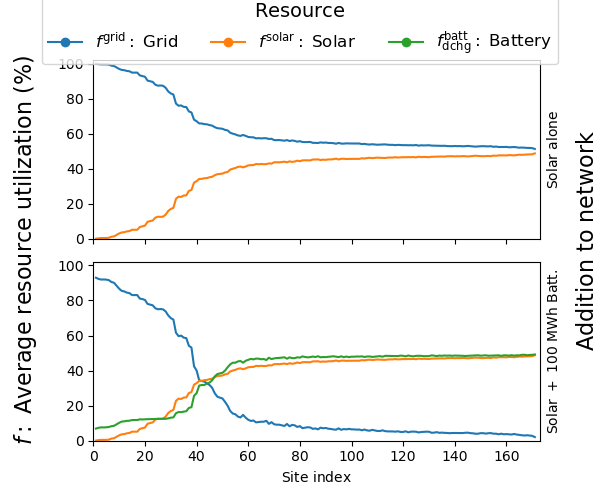

In [52]:
fig, ax = subplots(2, 1, figsize=(6, 5), sharex=True, sharey=True)

ax[0].plot(arange(171) + 1, fractions_optimal[sorted_df_reduced_gid, 1, 0, 2]*1e2, "-", ms=6, label=r"$\textrm{Grid}$")
ax[0].plot(arange(171) + 1, fractions_optimal[sorted_df_reduced_gid, 1, 0, 0]*1e2, "-", ms=6, label=r"$\textrm{Solar}$")

ax[1].plot(arange(171) + 1, fractions_optimal[sorted_df_reduced_gid, 1, 1, 2]*1e2, "-", ms=6, label=r"$\textrm{Grid}$")
ax[1].plot(arange(171) + 1, fractions_optimal[sorted_df_reduced_gid, 1, 1, 0]*1e2, "-", ms=6, label=r"$\textrm{Solar}$")
ax[1].plot(arange(171) + 1, fractions_optimal[sorted_df_reduced_gid, 1, 1, 1]*1e2, "-", ms=6, label=r"$\textrm{Battery}$")

ax[0].set_ylabel(r"$\mathrm{Solar\ alone}$")
ax[0].yaxis.set_label_position("right")
ax[1].set_ylabel(r"$\mathrm{Solar\ +\ 100\ MWh\ Batt.}$")
ax[1].yaxis.set_label_position("right")

ax[0].set_ylim((0, 102))
ax[1].set_ylim((0, 102))

ax[-1].set_xlim((0, 173))
ax[-1].set_xlabel(r"$\mathrm{Site\ index}$")

fig.supylabel(r"$f:\ \mathrm{Average\ resource\ utilization\ (\%)}$", fontsize=16)

fig.tight_layout()
fig.align_labels()

fig.legend(
    [Line2D([], [], marker="o", ms=6, ls="-", color=f"C{i}") for i in range(3)], 
    [r"$f^{\mathrm{grid}}:\ \mathrm{Grid}$", r"$f^{\mathrm{solar}}:\ \mathrm{Solar}$", r"$f_{\mathrm{dchg}}^{\mathrm{batt}}:\ \mathrm{Battery}$"],
    loc="center", prop=dict(size=12), ncol=3, 
    title=r"$\mathrm{Resource}$", title_fontsize=14,
    bbox_to_anchor=(0.5, 0.94), 
    bbox_transform=fig.transFigure
    )

fig.text(
    0.98, 0.52, 
    r"$\mathrm{Addition\ to\ network}$",
    ha="center", va="center", 
    fontsize=16, rotation="vertical"
    )

fig.subplots_adjust(top=0.88, right=0.9)

fig.savefig("../figures/FigS13.pdf")

# Figure S14: Average resource utilization to charge a 100 MWh battery for each viable site in the Port of Savannah region

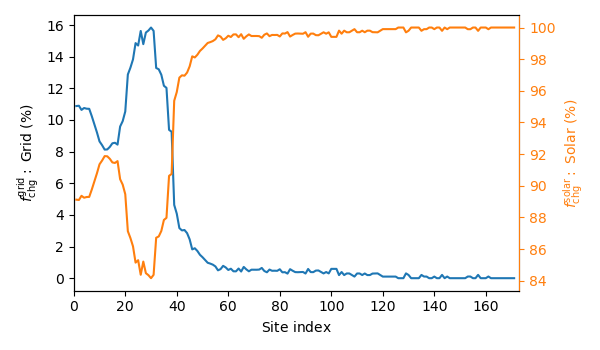

In [53]:
fig, ax = subplots(1, 1, figsize=(6, 3.5), sharex=True)

ax.plot(arange(171) + 1, fractions_batt_charge_optimal[sorted_df_reduced_gid, 1, 1, 1]*1e2, "-", ms=6)
ax.set_ylabel(r"$f_{\mathrm{chg}}^{\mathrm{grid}}:\ \mathrm{Grid\ (\%)}$")

ax_twin = ax.twinx()
ax_twin.spines["right"].set_visible(True)
ax_twin.spines["right"].set_color("C1")
ax_twin.tick_params(which="both", colors="C1")

ax_twin.plot(arange(171) + 1, fractions_batt_charge_optimal[sorted_df_reduced_gid, 1, 1, 0]*1e2, "C1-", ms=6)
ax_twin.set_ylabel(r"$f_{\mathrm{chg}}^{\mathrm{solar}}:\ \mathrm{Solar\ (\%)}$", color="C1")

ax.set_xlim((0, 173))
ax.set_xlabel(r"$\mathrm{Site\ index}$")

fig.tight_layout()
fig.align_labels()

fig.savefig("../figures/FigS14.pdf")

# Figure S15: Total ystem cost of deploying microgrid for each of the viable sites within the region

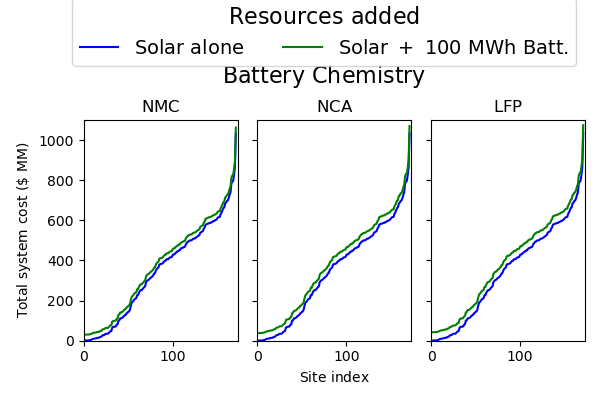

In [55]:
fig, ax = subplots(1, 3, figsize=(6, 4), sharex=True, sharey=True)

ax[0].plot(arange(171) + 1, site_cost_total_NMC[0, 1, :]/1e6, "b-")
ax[0].plot(arange(171) + 1, site_cost_total_NMC[1, 1, :]/1e6, "g-")
ax[0].set_title(r"$\mathrm{NMC}$")

ax[1].plot(arange(171) + 1, site_cost_total_NCA[0, 1, :]/1e6, "b-")
ax[1].plot(arange(171) + 1, site_cost_total_NCA[1, 1, :]/1e6, "g-")
ax[1].set_title(r"$\mathrm{NCA}$")

ax[2].plot(arange(171) + 1, site_cost_total_LFP[0, 1, :]/1e6, "b-")
ax[2].plot(arange(171) + 1, site_cost_total_LFP[1, 1, :]/1e6, "g-")
ax[2].set_title(r"$\mathrm{LFP}$")

ax[1].set_xlim((0, 173))
ax[1].set_ylim((0, 1_100))

ax[0].set_ylabel(r"$\mathrm{Total\ system\ cost\ (\$\ MM)}$")
ax[1].set_xlabel(r"$\mathrm{Site\ index}$")

fig.legend(
    [Line2D([], [], color="b"), Line2D([], [], color="g")],
    [r"$\mathrm{Solar\ alone}$", r"$\mathrm{Solar\ +\ 100\ MWh\ Batt.}$"],
    loc="center", prop=dict(size=14), ncol=2,
    title=r"$\mathrm{Resources\ added}$", title_fontsize=16,
    bbox_to_anchor=(0.54, 0.92)
    )

fig.tight_layout()
fig.align_labels()

fig.suptitle(
    r"$\mathrm{Battery\ Chemistry}$", 
    x=0.54, y=0.81, 
    ha="center", va="center",
    fontsize=16, 
    )

fig.subplots_adjust(top=0.7)

fig.savefig("../figures/FigS15.pdf")

# Figure S16: Levelized cost of photovoltaic recharge for each of the viable sites in the region

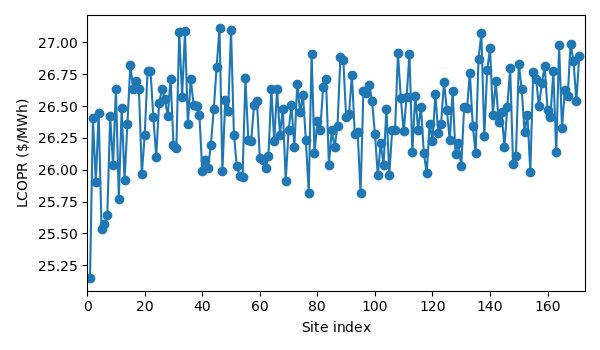

In [56]:
fig, ax = subplots(figsize=(6, 3.5))

ax.plot(arange(171) + 1, site_LCOPR_woReturns[:,1], "o-", ms=6)

ax.set_xlim((0, 173))

ax.set_xlabel(r"$\mathrm{Site\ index}$")
ax.set_ylabel(r"$\mathrm{LCOPR\ (\$/MWh)}$")
ax.ticklabel_format(style="plain")

fig.tight_layout()
fig.savefig("../figures/FigS16.pdf")